<a href="https://colab.research.google.com/github/Vinamra-15/Chat-Room/blob/main/Image_Encryption_(Minor_Project)_handXRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Take 512*512 JPG image as Input**

In [2]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2 
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import math

**Diffusion**

In [3]:
def logisticMapKeyGen(initCondition, controlParameter, NoOfKeys) -> list:
  key = []  # list for storing the no. of keys for ecryption

  for count in range(NoOfKeys):
      # .`. x = initialCondition , r = controlParameter
      # x = r * x * (1-x) logistic map
      # logistic map for key geniration
      initCondition = controlParameter *initCondition*(1 - initCondition)

      # this is a key for for encryption as well decryption
      # taking mod 256 because  is for 8bit image
      key.append(int((initCondition*pow(10, 16)) % 256))

  return key
  

In [4]:
chaotic_key = logisticMapKeyGen(0.9,4,512*512)
print(chaotic_key)

[255, 0, 0, 2, 150, 172, 44, 19, 80, 180, 244, 64, 49, 43, 135, 77, 78, 196, 157, 161, 193, 24, 24, 129, 130, 8, 103, 217, 44, 221, 71, 219, 112, 50, 137, 57, 188, 251, 3, 69, 142, 136, 235, 213, 219, 248, 45, 170, 175, 28, 40, 89, 144, 41, 63, 86, 20, 51, 57, 134, 2, 206, 62, 124, 81, 132, 93, 29, 222, 185, 212, 47, 178, 107, 51, 196, 251, 126, 232, 65, 230, 161, 114, 214, 103, 191, 163, 30, 72, 19, 78, 204, 54, 82, 26, 210, 63, 68, 45, 75, 212, 166, 75, 196, 209, 18, 205, 102, 38, 113, 222, 194, 84, 148, 159, 196, 27, 113, 120, 184, 5, 84, 130, 227, 237, 126, 194, 74, 123, 246, 181, 253, 156, 117, 89, 87, 162, 26, 143, 133, 94, 231, 56, 43, 70, 79, 210, 248, 229, 107, 39, 65, 47, 110, 140, 125, 200, 83, 113, 135, 38, 151, 114, 124, 167, 210, 15, 96, 216, 101, 99, 25, 74, 218, 131, 240, 0, 8, 16, 129, 97, 116, 245, 8, 226, 237, 69, 238, 140, 127, 164, 63, 30, 212, 88, 224, 10, 54, 36, 36, 116, 208, 129, 228, 30, 83, 23, 214, 59, 136, 1, 110, 204, 138, 16, 247, 51, 8, 64, 11, 2, 121, 2

In [5]:
def diffusion(imageName):
  i = 0
  img = cv2.imread(imageName)
  for r in range(512):
    for c in range(512):
      img[r][c] = img[r][c]^chaotic_key[i]
      i+=1
  cv2.imwrite(imageName.split('.')[0] + "_Diffused.png", img)
  return img

**Confusion**

In [6]:
def arnoldCatEncryption(imageName):
  
  img = cv2.imread(imageName)
  w,h,b = img.shape
  n=max(h,w)
  encrypted_image = img.copy()

  #print(img.shape,encrypted_image.shape)
  for x in range(n):
    for y in range(n):
      encrypted_image[x][y]=img[(2*x+y)%n][(y+x)%n]

  cv2.imwrite(imageName.split('.')[0] + "_ArnoldcatEnc.png", encrypted_image)
  return encrypted_image


In [7]:
def arnoldCatDecryption(imageName):
  img = cv2.imread(imageName)
  h,w,_=img.shape
  decrypted_image = img.copy()
  #rectangular images are not allowed 
  if h!=w:
    raise Exception("Expected a square image")

  for x in range(h):
    for y in range(h):
      decrypted_image[x][y]=img[(x-y)%h][((2*y)-x)%h]

  cv2.imwrite(imageName.split('.')[0] + "_ArnoldcatDec.png",decrypted_image)
  return decrypted_image

**Helper Function for Henon Map**

In [8]:
def getImageMatrix(imageName):
    im = Image.open(imageName) 
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [9]:
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA')
    pix = im.load()
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0]

In [10]:
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit)
    return decimal

In [11]:
def genHenonMap(dimension, key):
    x = key[0]
    y = key[1]
    sequenceSize = dimension * dimension * 8 #Total Number of bitSequence produced
    bitSequence = []    #Each bitSequence contains 8 bits
    byteArray = []      #Each byteArray contains m( i.e 512 in this case) bitSequence
    TImageMatrix = []   #Each TImageMatrix contains m*n byteArray( i.e 512 byteArray in this case)
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x**2
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bitSequence.append(bit)
        except:
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix

**Henon Map Encryption**

In [12]:
def henonEncryption(imageName,key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(imageName)
    transformationMatrix = genHenonMap(512, key)
    resultantMatrix = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:    
            resultantMatrix.append(row)
        except:
            resultantMatrix = [row]
    if color:
      im = Image.new("RGB", (dimensionX, dimensionY))
    else: 
      im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = resultantMatrix[x][y]
    im.save(imageName.split('.')[0] + "_HenonEnc.png", "PNG")
    

In [13]:
def henonDecryption(imageNameEnc, key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(imageNameEnc)
    transformationMatrix = genHenonMap(512, key)
    pil_im = Image.open(imageNameEnc, 'r')
    imshow(np.asarray(pil_im))
    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else: 
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageNameEnc.split('.')[0] + "_HenonDec.png", "PNG")

## **Encryption**

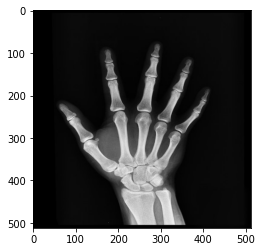

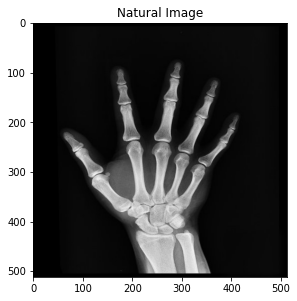

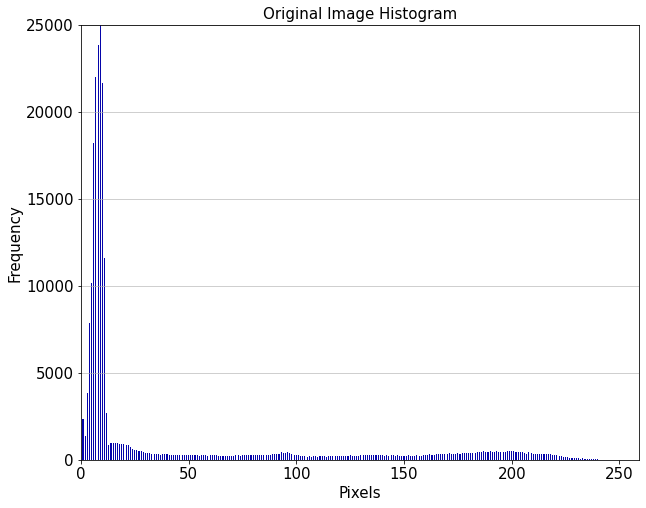

In [14]:
imageName = "handXRay"
ext = ".png"  #extension of images to be created
im = Image.open(imageName+".jpg", 'r')
imshow(np.asarray(im))

mri_rgb = cv2.imread(imageName+".jpg")
mri_gray = cv2.cvtColor(mri_rgb,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=[10,10])

plt.subplot(121)
plt.imshow(mri_rgb[:,:,::-1])
plt.title("Natural Image")
plt.show()

hist, edges = np.histogram(mri_gray,bins=range(260))
plt.figure(figsize=[10,8])

plt.bar(edges[:-1], hist, width = 0.5, color='#0504aa')
plt.xlim(min(edges), max(edges))
plt.ylim(0,25000)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixels',fontsize=15)
plt.ylabel('Frequency of Pixels',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Original Image Histogram',fontsize=15)
plt.show()








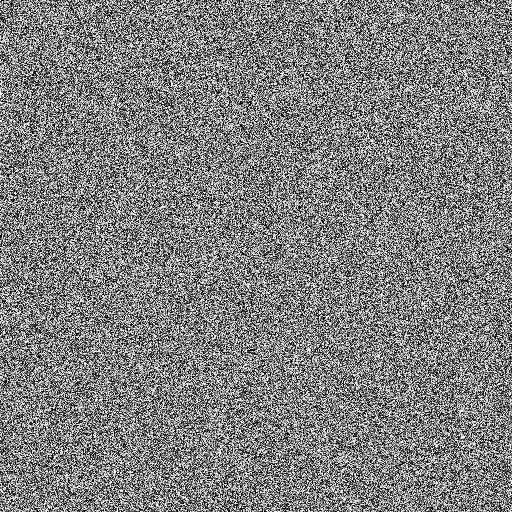

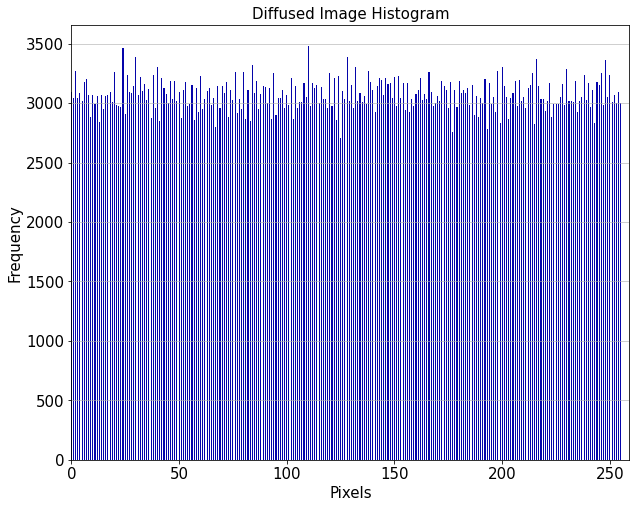

In [15]:

diffused = diffusion(imageName+".jpg")
cv2_imshow(diffused)
hist, edges = np.histogram(diffused,bins=range(260))
plt.figure(figsize=[10,8])

plt.bar(edges[:-1], hist, width = 0.5, color='#0504aa')
plt.xlim(min(edges), max(edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixels',fontsize=15)
plt.ylabel('Frequency of Pixels',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Diffused Image Histogram',fontsize=15)
plt.show()


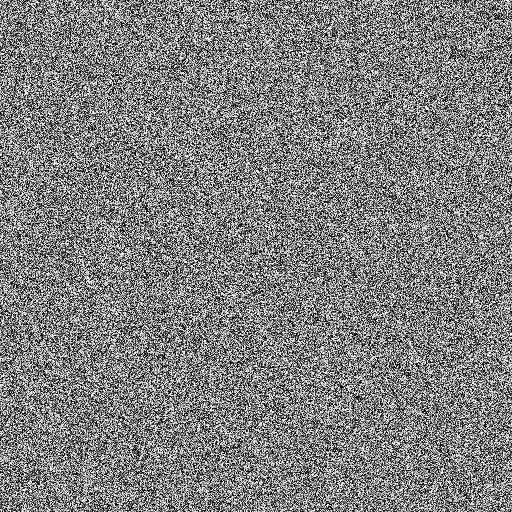

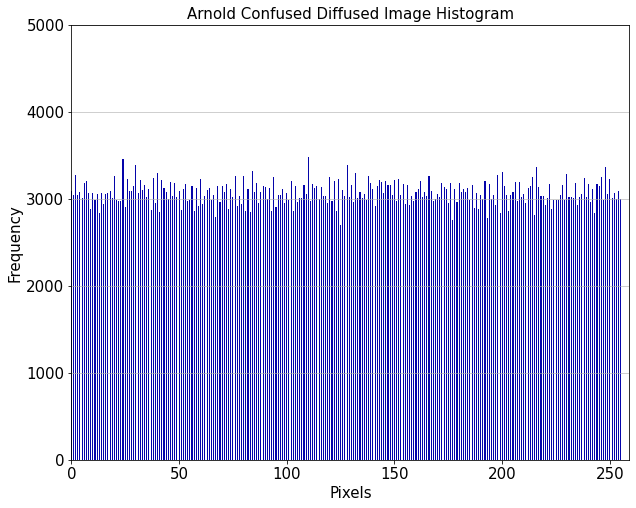

In [16]:
arnold_encrypted = arnoldCatEncryption(imageName+"_Diffused"+ext)
cv2_imshow(arnold_encrypted)
hist, edges = np.histogram(arnold_encrypted,bins=range(260))
plt.figure(figsize=[10,8])

plt.bar(edges[:-1], hist, width = 0.5, color='#0504aa')
plt.xlim(min(edges), max(edges))
plt.ylim(0,5000)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixels',fontsize=15)
plt.ylabel('Frequency of Pixels',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Arnold Confused Diffused Image Histogram',fontsize=15)
plt.show()

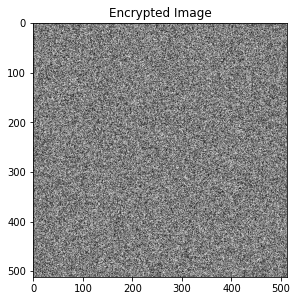

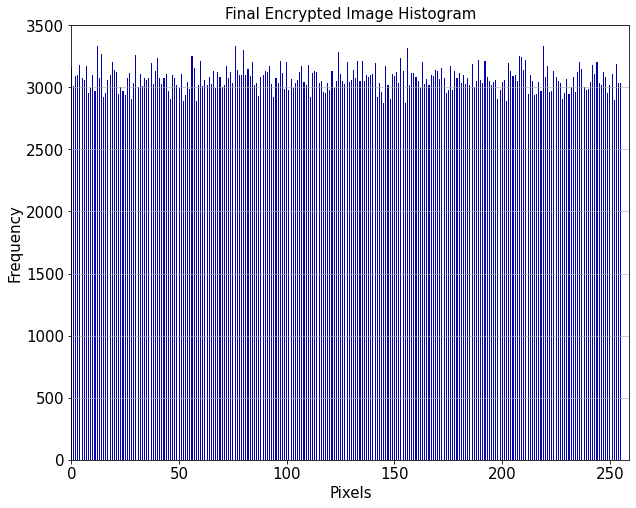

In [17]:
key = (0.1,0.1)
henonEncryption(imageName+"_Diffused_ArnoldcatEnc.png",key)


encr_gray = cv2.imread(imageName+"_Diffused_ArnoldcatEnc_HenonEnc.png")

plt.figure(figsize=[10,10])

plt.subplot(121)
plt.imshow(encr_gray[:,:,::-1])
plt.title("Encrypted Image")
plt.show()

hist, edges = np.histogram(encr_gray,bins=range(260))
plt.figure(figsize=[10,8])

plt.bar(edges[:-1], hist, width = 0.5, color='#0504aa')
plt.xlim(min(edges), max(edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixels',fontsize=15)
plt.ylabel('Frequency of Pixels',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Final Encrypted Image Histogram',fontsize=15)
plt.show()

## **Decryption**

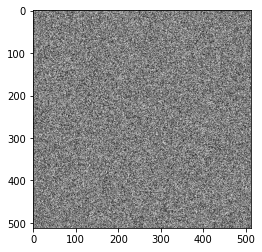

In [18]:
henonDecryption(imageName + "_Diffused_ArnoldcatEnc_HenonEnc"+ext,key)


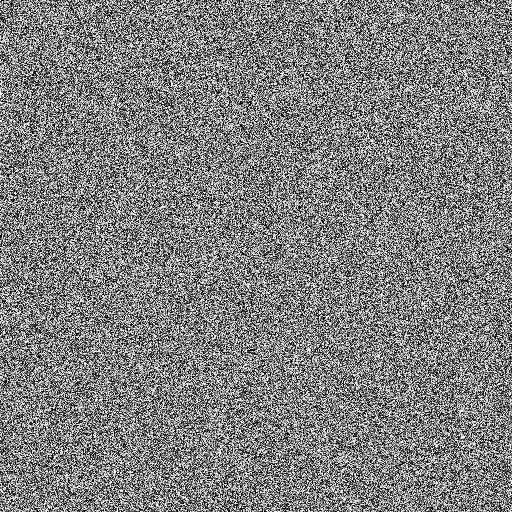

In [19]:
arnold_decrypted = arnoldCatDecryption(imageName + "_Diffused_ArnoldcatEnc_HenonEnc_HenonDec"+ext)
cv2_imshow(arnold_decrypted)

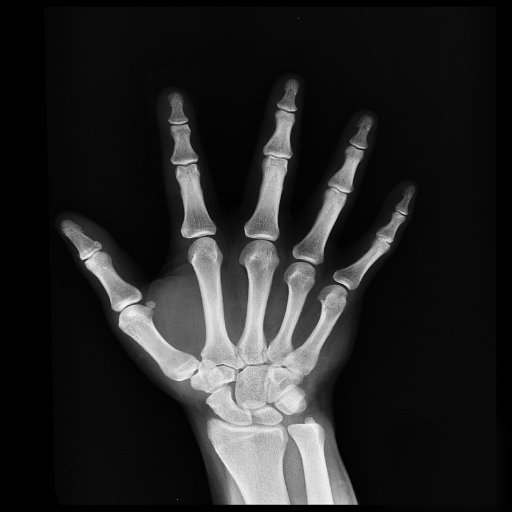

In [20]:
diffusion_decrypted = diffusion(imageName + "_Diffused_ArnoldcatEnc_HenonEnc_HenonDec_ArnoldcatDec"+ext)
cv2_imshow(diffusion_decrypted)

**Parameters Evaluation**

In [21]:
def uaci(img1, img2):
  height,width=img1.shape
  value = 0
  for y in range(height):
    for x in range(width):
      value+=(abs(int(img1[x,y])-int(img2[x,y])))
  
  value = value*100/(width*height*255)
  return value

encImg1 = cv2.imread(imageName + "_Diffused_ArnoldcatEnc_HenonEnc.png",0)
encImg2 = cv2.imread(imageName+".jpg",0)

print('UACI: ', uaci(encImg1,encImg2))


UACI:  43.429073258942246


In [22]:
def sumofpixelval(height,width,img1,img2):
  matrix = np.empty([width,height])

  for y in range(0,height):
    for x in range(0,width):
      if(img1[x,y]==img2[x,y]):
        matrix[x,y] = 0
      else:
        matrix[x,y] = 1
      
  psum = 0
  for y in range(0,height):
    for x in range(0,width):
      psum = matrix[x,y] + psum
  
  return psum

def npcr(img1,img2):
  height = img1.shape[0]
  width = img2.shape[1]

  npcrv = ((sumofpixelval(height,width,img1,img2)/(height*width))*100)
  return npcrv

encImg1 = cv2.imread(imageName+"_Diffused_ArnoldcatEnc_HenonEnc.png",0)
encImg2 = cv2.imread(imageName+".jpg",0)

print('NPCR: ', npcr(encImg1,encImg2))



NPCR:  99.609375


In [23]:
def colCorrelation(pixel):
  h = pixel.shape[0]
  N = h
  c1 = 200
  c2 = 201
  ex = 0
  ey = 0
  dx = 0
  dy = 0
  cov = 0

  for i in range(h):
    ex+=pixel[i][c1]

  ex = ex/N


  for i in range(h):
    ey+=pixel[i][c2]
  
  ey = ey/N

  for i in range(h):
    dx+=math.pow((pixel[i][c1]-ex),2)
  
  dx = dx/N

  for i in range(h):
    dy+=math.pow((pixel[i][c2]-ey),2)
  
  dy = dy/N


  xi = 0
  yi = 0
  zi = 0

  for i in range(h):
    xi = pixel[i][c1]-ex
    yi = pixel[i][c2] - ey
    zi+=(xi*yi)

  cov = zi/N

  r = 0
  r = cov/(math.sqrt(dx)*math.sqrt(dy))
  print("\nColumn correlation = ",r)

imgOriginal = plt.imread(imageName+".jpg")[:,:,0]
imgDiffArnoldHenon = plt.imread(imageName+"_Diffused_ArnoldcatEnc_HenonEnc.png")[:,:,0]



print('Original Image: ',colCorrelation(imgOriginal))
print('Encrypted Image: ',colCorrelation(imgDiffArnoldHenon))








Column correlation =  0.9793161999373268
Original Image:  None

Column correlation =  -0.028011698975130825
Encrypted Image:  None


In [24]:
from scipy.special import entr
import skimage.measure    
entropyOriginal = skimage.measure.shannon_entropy(imgOriginal)
entropyEncrypted = skimage.measure.shannon_entropy(imgDiffArnoldHenon)
print('Original Image Entropy:',entropyOriginal)
print('Encrypted Image Entropy: ',entropyEncrypted)


Original Image Entropy: 5.364558664709767
Encrypted Image Entropy:  7.999355484984988
